# Titanic

To most, the Titanic may evokes imagery of a grand ship, a newspaper headline,
or maybe the iconic picture of Leo & Kate on the bow of the ship. To data
scientists, the Titanic often reminds us of our first dataset, a *real* dataset,
requiring vast amounts of cleaning, preprocessing, transformation, and
hyperparameter tuning.

Nevertheless, the Titanic dataset is a great place to start with data science
projects. It is a great place to start, covering a great variety of topics.

## Setup

### Download Data

In [3]:
import shutil
from pathlib import Path
import kagglehub

In [ ]:
def download_dataset(name: str) -> list[Path]:
    out_path = kagglehub.dataset_download(name)
    files = [path for path in Path(out_path).iterdir() if path.is_file()]
    if not files:
        raise FileNotFoundError(f"Download directory '{out_path}' is empty.")

    dest_files = [Path.cwd() / file.name for file in files]
    for src, dest in zip(files, dest_files):
        shutil.copy2(src, dest)
    
    return dest_files


files = download_dataset('yasserh/titanic-dataset')
files = [f for f in Path.cwd().iterdir() if f.suffix == '.csv']
print(f'Downloaded {len(files)} file(s):', end='\n\n')
print('\n'.join(file.name for file in files))

Downloaded 1 file(s):

Titanic-Dataset.csv


### Define Workflow

Before we start, let's define the scope of our workflow. I'm taking the steps
from the framework CRISP-DM (Cross-Industry Standard Process for Data Mining).
IBM has a useful introduction to this framework on their [website][1].

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

<!-- References -->

[1]: https://www.ibm.com/docs/en/spss-modeler/saas?topic=dm-crisp-help-overview

## 1. Business Understanding

### Business Objectives

Typically, we'll want to thoroughly understand the business side of things
before embarking on an analysis. This involves a lot of discussion with
stakeholders--the ones who feel the most impact from the problem at hand.

Perhaps we need an understanding of what went wrong on the Titanic in order to
prevent future disasters. Or, maybe we want to analyze the most impactful
features of passengers in their survival so as to determine the effect of
society norms in the early 20th century on a passenger surviving any kind of
disaster.

Regardless of the business case, we're looking to understand survival of
Titanic passengers and create a model to predict which passengers will survive.

### Assess the Situation

Here is where we would need to evaluate what resources we have available. If
our model was computationally intensive, what resources does our company have
with cloud computing? Are there other metadata or supplemental datasets that
may be useful here?

For our purpose, we simply have the dataset provided to us by Kaggle.
As we get further into the analysis, we can evaluate risks/contingencies based
on the cleanliness of the data.

### Determine the Goals

> *In short, what does success look like?*

Personally, I would love to see a model that can predict (with excellent
accuracy) which passengers will survive the Titanic. I anticipate that the
bare features alone won't cut it, so a successful model will likely have
well-engineered features that make use of the raw data. Finally, a successful
project would be one that considers multiple models, using cross-validation,
and implements the most successful one.

Summarizing these goals, we want to:

1. Create a machine learning model to predict which passengers survive
2. Have excellent performance (to be clarified later)
3. Develop well-engineered, meaningful features
4. Utilize cross-validation to select the best-performing model

### Formulate a Project Plan

What kind of technologies do we want to use, and how will we implement them?

We'll need to revisit this as we get further understanding of the data, but
initially, we could make use of:

- Logistic Regression Classifier
- Naive-Bayes Classifier
- k-Nearest Neighbors
- Decision Tree Classifier
- Random Forest Classifier
- Support Vector Classifier

Much of these are quickly available in the Scikit-Learn library. In addition,
this library also provides tools for:

- Train-Test splits
- K-fold cross-validation
- Stratified K-Fold cross-validation
- Grid search CV
- Accuracy metrics

## 2. Data Understanding

This stage is more commonly referred to as EDA, or exploratory data analysis.
We want to import our data and understand its structure, what problems
we need to fix, and any other factors that may affect our workflow.

### Load Data

In [15]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns

In [7]:
assert len(files) == 1
file = files[0]
assert file.suffix.lower() == '.csv'
df = pd.read_csv(file)
print('Loaded data into variable `df`')

Loaded data into variable `df`


### Describe our Data

Here, we want to understand some high-level characteristics of our data, namely:

1. Data preview (i.e., the head)
2. Data types
3. Descriptive statistics
4. Null value distribution

In [8]:
# Display first 10 rows
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


> **Notes:**
>
> - `PassengerId` looks like a simple incrementing ID; this should be set as
>   the index.
> - `Survived` is our target, a one-hot variable with 1 = "Survived"
> - `PClass` seems to be a numeric value indicating first, second, or third
>   class rooms on the ship.
> - `Name` doesn't just include first/last name, it also includes title. This
>   may be useful for an engineered feature.
> - `Sex` seems to be only male/female -- this should be converted to a one-hot
>   variable.
> - `Age` - I see one NaN value here. I also notice it got represented as a
>   float -- is there a passenger whose age isn't a whole integer?
> - `SibSp` - Not immediately clear, but this one represents the number of
>   siblings or spouses on the Titanic. I.e., other people in their group of
>   the same age.
> - `Parch` - Like `SibSp`, this isn't immediately clear, but the documentation
>   says this represents the number of parents/children in their group. Both
>   this column and `SibSp` may be useful to quantify the total people in the
>   party's group.
> - `Ticket` - Some of these are integers (ticket number), but some also have
>   information like 'A/5', 'PC', 'STON/O2'. Will need to dig further to
>   understand this field.
> - `Fare` - How much was paid for the ticket. Do higher-paying customers have
>   better chance of survival?
> - `Cabin` - The cabin number. May be useful if `Pclass` isn't available.
> - `Embarked` - S = Southampton, C = Cherbourg, Q = Queenstown. Note that the
>   order here is not arbitrary: This is the order of ports that the Titanic
>   visited.

In [9]:
# Display data types
display(df.dtypes.value_counts().to_frame('# Columns'))
display(df.dtypes.to_frame(name='Type'))

,# Columns
int64,5
object,5
float64,2


,Type
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


> **Notes:**
>
> As mentioned above, it's interesting that the `Age` field came in as a float.
> It may make more sense to convert this to an integer, unless that partial
> year gives us some kind of information.
>
> Also, while it may be tempting to get rid of the 5 string fields, we can't
> disregard this yet -- we don't have a ton of information to work with, so
> we'll want to extract as much information as possible.

In [10]:
# Describe the data
df.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


> **Notes:**
>
> - `PassengerId` - Irrelevant, as this is just an index.
> - `Survived` - The min/max don't tell us much, but the mean is useful -- 38%
>   of passengers survived, so around 1 in 3.
> - `Pclass` - This is an ordinal field, not numeric, but it does tell us that
>   the average passenger was between class 2 and 3.
> - `Age` - There is a variety of ages on the Titanic, with the typical
>   passenger being about 28-29 years of age, the youngest was 0.42 (5 months)
>   and the eldest was 80 years old. Most passengers (25-75 percentile) were
>   between 20-38 years old.
> - `SibSp` - Most passengers (>50%) didn't have any siblings or spouses. Even
>   the 75% percentile was just 1 other person of their age. The largest group
>   was 8 siblings/spouses (almost certainly 8 siblings).
> - `Parch` - The vast majority (>75%) didn't have any parents or children
>   aboard, but one group had 6 parents/children.
> - `Fare` - On average, passengers paid $32.20 with a *wide* standard deviation
>   of $49.69. Most passengers paid between $8-31, with the wealthiest
>   passenger paying a whopping $512.33 for their fare.

In [11]:
# Understand the null distribution
null_distribution = pd.DataFrame({
    'Null Count': df.isna().sum().map(lambda n: '' if n == 0 else f'{n:,}'),
    '% Null': df.isna().mean().map(lambda p: '' if p == 0 else f'{p:.2%}')
})
null_distribution = null_distribution.loc[null_distribution.iloc[:,0] != '']

null_distribution.T

,Age,Cabin,Embarked
Null Count,177,687,2
% Null,19.87%,77.10%,0.22%


> **Notes:**
>
> Most fields don't have any null values, which is helpful. The most
> problematic field will be Cabin, but from looking at the top 10 rows, it
> doesn't seem like this will be useful. We may just drop this field all
> together.
>
> `Age` is an interesting one: there is a significant amount of nulls here, but
> it may be quite a useful field. We could look at doing a quick predictive
> model based on `Name`, `Fare`, `Embarked`, `SibSp`, and `Parch`. Or, if we
> want something quick, we could do a simple median-value or mean-value
> imputation.
>
> `Embarked` will probably require a quick manual fix here, since it's only
> 2 records.

### Explore the Data

Now for the fun part of EDA--the visuals! Let's try to visualize what our
data looks like. Each cell will be looking to answer a preliminary question
or one raised in the data description step prior to this.

In [18]:
def add_bar_labels(
        ax: Axes,
        fmt: str,
        label_type='center',
        color='white'
) -> None:
    for container in ax.containers:
        ax.bar_label(container, label_type=label_type, fmt=fmt, color=color)
    return

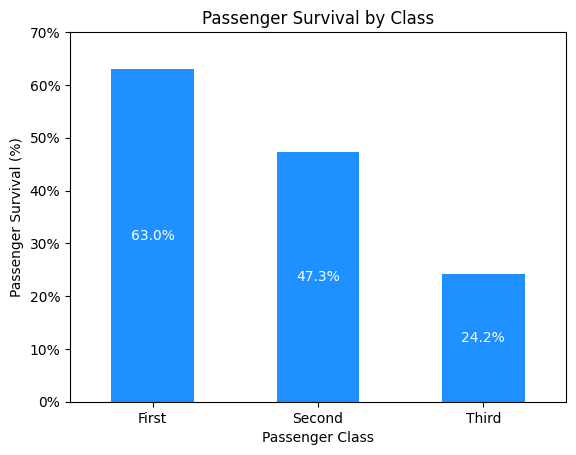

In [19]:
# How did class play a role in survival?
df_class = df.groupby('Pclass', as_index=False)[['Survived']].mean()
ax = df_class.plot(
    kind='bar',
    x='Pclass',
    y='Survived',
    xlabel='Passenger Class',
    ylabel='Passenger Survival (%)',
    rot=0,
    color='dodgerblue',
    legend=False,
    title='Passenger Survival by Class'
)

# X Labels
ax.set_xticks(range(3), ['First', 'Second', 'Third'])

# Y Labels
yticks = ax.get_yticks()
ytick_labels = map('{:.0%}'.format, yticks)
ax.set_yticks(yticks, ytick_labels)

add_bar_labels(ax, fmt='{:.1%}')

# ax.set_title('Passenger Survival by Class', size=14, pad=12)
plt.show()

> **Notes:**
>
> Unsurprisingly, first-class passengers has the best chance of surviving,
> followed by second, then third class.

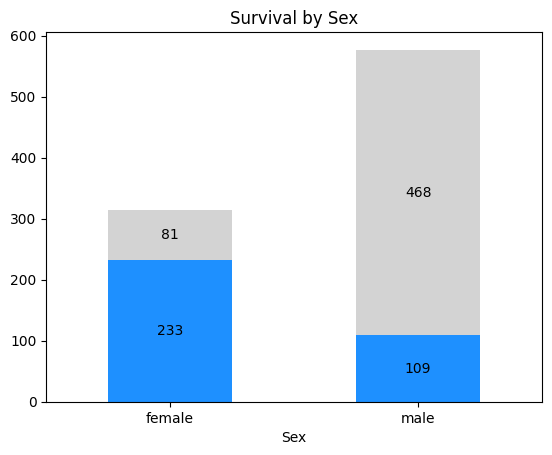

In [21]:
# What was the distribution of sex on the Titanic? How did this affect surival?

# Create pivot-table by sex
df_sex = df.groupby(['Sex', 'Survived'], as_index=False)[['PassengerId']].count()
df_sex = df_sex.pivot(index='Sex', columns='Survived', values='PassengerId')
df_sex.rename(inplace=True, columns=lambda s: ['No', 'Yes'][s])
df_sex.sort_index(inplace=True, axis=1, ascending=False)  # Show 'Yes' first

# Plot data
ax = df_sex.plot(
    kind='bar',
    stacked=True,
    color=['dodgerblue', 'lightgray'],
    legend=False,
    title='Survival by Sex',
    rot=0,
)
add_bar_labels(ax, fmt='{:,.0f}', color='black')
plt.show()

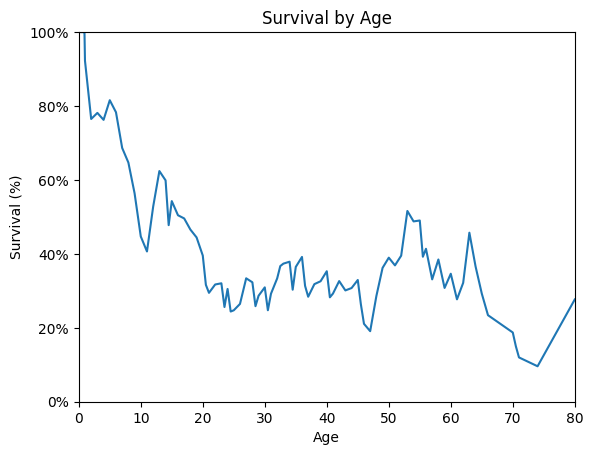

In [60]:
# How does Age play an impact in survival?
df_age = df.groupby('Age', as_index=False)[['Survived']].mean()
df_age['Survived'] = df_age['Survived'].ewm(alpha=0.2).mean()

ax = df_age.plot(
    kind='line',
    x='Age',
    y='Survived',
    legend=False,
    title='Survival by Age',
    xlabel='Age',
    ylabel='Survival (%)',
    xlim=(0, 80),
    ylim=(0, 1),
)

yticks = ax.get_yticks()
ytick_labels = map('{:.0%}'.format, yticks)
ax.set_yticks(yticks, ytick_labels)
plt.show()

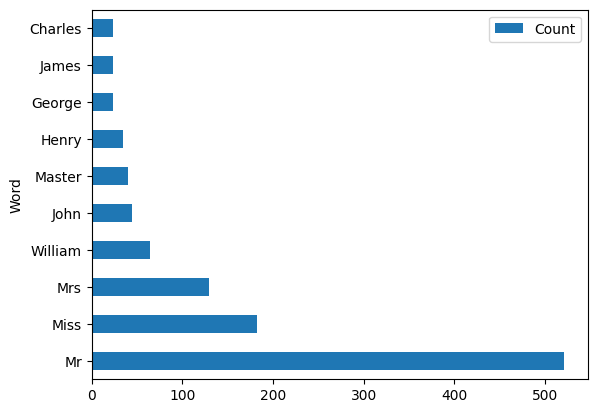

In [ ]:
# What are the most common words within "Name"?
is_alnum_or_space = lambda s: s.isalpha() or s == ' '

name_words = str.split(' '.join(
    df['Name'].map(lambda name: ''.join(filter(is_alnum_or_space, name)))
))
word_counts = pd.Series(name_words).value_counts().reset_index()
word_counts.columns = ['Word', 'Count']

ax = word_counts.head(10).plot(
    kind='barh',
    x='Word',
    y='Count',
)

plt.show()

> **Note:**
>
> It doesn't seem like this extracts much information, since common names like
> "William", "John", and "Henry" are captured as common words in names. But,
> we may be able to extract the person's title from the structure of the name:
> nearly every name is structured as "LastName, Title. FirstName (Alt Name)"

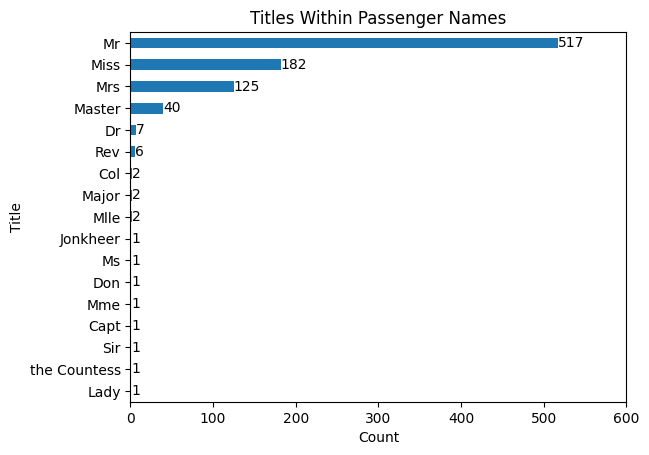

In [79]:
# What are the most common titles?
def extract_name_title(name: str) -> str:
    '''
    Get a person's title out of their name.
    '''
    title_and_firstname = name.split(', ')[1]
    title = title_and_firstname.split('. ')[0]
    return title


name_titles = df['Name'].map(extract_name_title).value_counts().to_frame()
name_titles = name_titles.reset_index()
name_titles.columns = ['Title', 'Count']
name_titles = name_titles.sort_values(by='Count', ascending=True)
ax = name_titles.plot(
    kind='barh',
    x='Title',
    y='Count',
    xlim=(0, 600),
    title='Titles Within Passenger Names',
    legend=False,
    xlabel='Count',
    ylabel='Title',
)
add_bar_labels(ax, fmt='{:.0f}', label_type='edge', color='black')
plt.show()

## 3. Data Preparation

## 4. Modeling

## 5. Evaluation

## 6. Deployment